## House - Price Prediction

##### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib 
import pickle
import json

##### Load the Dataset

In [2]:
housing_data = pd.read_csv('bengaluru_house_prices.csv')

In [3]:
housing_data.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


#### Exploratory Data Analysis

In [4]:
housing_data.shape

(13320, 9)

In [5]:
housing_data.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [6]:
housing_data['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [7]:
housing_data['location'].value_counts()

location
Whitefield                        540
Sarjapur  Road                    399
Electronic City                   302
Kanakpura Road                    273
Thanisandra                       234
                                 ... 
Bapuji Layout                       1
1st Stage Radha Krishna Layout      1
BEML Layout 5th stage               1
singapura paradise                  1
Abshot Layout                       1
Name: count, Length: 1305, dtype: int64

In [8]:
housing_data.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


where,

_count_ : count or number of values (ignoring null values)

_mean_ : average of all the values 

_std_ : standard deviation, distance of the value from mean

_min_ : minimum value

_25%_ : 25% values less than the dispalyed value

_50%_ : 50% values less than the dispalyed value

_75%_ : 75% values less than the dispalyed value

_max_ : maximum value

In [9]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


##### Data Cleaning

##### _Drop Unnecessary Features_

In [10]:
data = housing_data.drop(['area_type', 'society', 'balcony', 'availability'], axis='columns')

data.shape

(13320, 5)

##### _Handle Missing Values_

In [11]:
data.isnull()

,location,size,total_sqft,bath,price
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
13315,False,False,False,False,False
13316,False,False,False,False,False
13317,False,False,False,False,False
13318,False,False,False,False,False


To take care of missing attributes, there're three options:

* Get rid of the missing data points  
* Get rid of the whole attribute
* Set the value to some value(0, mean, meadian)

In [12]:
data.isnull().sum() 

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [13]:
data = data.dropna()

In [14]:
data.isnull().sum() 

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

##### Feature Engineering

In [15]:
data['bhk'] = data['size'].apply(lambda x:int(x.split(' ')[0]))

data.bhk.unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

In [16]:
data = data.drop(['size'], axis='columns')

data.head()

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056,2.0,39.07,2
1,Chikka Tirupathi,2600,5.0,120.00,4
2,Uttarahalli,1440,2.0,62.00,3
3,Lingadheeranahalli,1521,3.0,95.00,3
4,Kothanur,1200,2.0,51.00,2


##### Explore Total SQFT Feature

In [17]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [18]:
data[~data['total_sqft'].apply(is_float)].head(10)

,location,total_sqft,bath,price,bhk
30,Yelahanka,2100 - 2850,4.0,186.000,4
122,Hebbal,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,1042 - 1105,2.0,54.005,2
165,Sarjapur,1145 - 1340,2.0,43.490,2
188,KR Puram,1015 - 1540,2.0,56.800,2
410,Kengeri,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,1195 - 1440,2.0,63.770,2
648,Arekere,4125Perch,9.0,265.000,9
661,Yelahanka,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,3090 - 5002,4.0,445.000,4


The sqft data can be a _range_, so taking Average of Min & Max value in the the range for such values. 

The sqft data that's in _sqm_ can be converted into _sqft_ using unit conversion.

In [19]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None 

In [20]:
data.total_sqft = data.total_sqft.apply(convert_sqft_to_num)

data =data[data.total_sqft.notnull()]

data.head()

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056.0,2.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Uttarahalli,1440.0,2.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Kothanur,1200.0,2.0,51.00,2


In [21]:
data.loc[30]

location      Yelahanka
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

##### Add New Feature 

In [22]:
# adding price per squaare feet

data['price_per_sqft'] = data['price']*100000 / data['total_sqft']

data.head()

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


In [23]:
data['price_per_sqft'].describe()

count    1.320000e+04
mean     7.920759e+03
std      1.067272e+05
min      2.678298e+02
25%      4.267701e+03
50%      5.438331e+03
75%      7.317073e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

In [24]:
# saving the file

#data.to_csv("banglore_housing_price.csv", index=False)

##### Examine Locations

Locations is a categorical value, thus dimensionality reduction technique need to be applied on that to reduce its number.

In [25]:
data.location = data.location.apply(lambda x: x.strip())

loc_stats = data['location'].value_counts(ascending=False)

loc_stats

location
Whitefield                   533
Sarjapur  Road               392
Electronic City              304
Kanakpura Road               264
Thanisandra                  235
                            ... 
Rajanna Layout                 1
Subramanyanagar                1
Lakshmipura Vidyaanyapura      1
Malur Hosur Road               1
Abshot Layout                  1
Name: count, Length: 1287, dtype: int64

In [26]:
loc_stats.values.sum()

13200

In [27]:
len(loc_stats)

1287

In [28]:
len(loc_stats[loc_stats>10])

240

In [29]:
len(loc_stats[loc_stats<=10])

1047

##### Dimensionality Reductions

Tag locations having less than 10 data points as'Other'. This reduces the number of categories and there're fewer dummy columns.

In [30]:
loc_stats[loc_stats<=10]

location
BTM 1st Stage                10
Gunjur Palya                 10
Nagappa Reddy Layout         10
Sector 1 HSR Layout          10
Thyagaraja Nagar             10
                             ..
Rajanna Layout                1
Subramanyanagar               1
Lakshmipura Vidyaanyapura     1
Malur Hosur Road              1
Abshot Layout                 1
Name: count, Length: 1047, dtype: int64

In [31]:
len(data.location.unique())

1287

In [32]:
data.location = data.location.apply(lambda x: 'other' if x in loc_stats[loc_stats<=10] else x)

len(data.location.unique())

241

In [33]:
data.tail()

,location,total_sqft,bath,price,bhk,price_per_sqft
13315,Whitefield,3453.0,4.0,231.0,5,6689.834926
13316,other,3600.0,5.0,400.0,4,11111.111111
13317,Raja Rajeshwari Nagar,1141.0,2.0,60.0,2,5258.545136
13318,Padmanabhanagar,4689.0,4.0,488.0,4,10407.336319
13319,Doddathoguru,550.0,1.0,17.0,1,3090.909091


##### Outlier Removal 

##### _Remove Outliers Using Business Logic_

Normally Square Ft Per Bedroom Is 300. Keeping the minimum threshold per bhk to be 300 sqt.

In [34]:
data[data.total_sqft/data.bhk<300].head()

,location,total_sqft,bath,price,bhk,price_per_sqft
9,other,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,1350.0,7.0,85.0,8,6296.296296
70,other,500.0,3.0,100.0,3,20000.000000


Data errors can be seen here clearly.

Like, for a 6 bedroom apartment the sqft is 1020 whereas for an 8 bhk one the sqft is 600.

In [35]:
data = data[~(data.total_sqft/data.bhk<300)]

data.shape

(12456, 6)

##### _Remove Outliers Using Standar Deviation & Mean_

In [36]:
data.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

The Min price per sqft is 267 whereas the Max is 176470. This shows a wide variation in property prices.

Remove Outliers per location using mean and standard deviation.

In [37]:
def remove_pps_outliers(df):                             
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

In [38]:
data = remove_pps_outliers(data)                # run this function only once as it will keep on removing data points whenever it's executed

data.shape

(10242, 6)

##### Plotting Graphs

In [39]:
# scatter chart for 2bhk & 3bhk propert prices for a given location 

def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='red',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='blue',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()


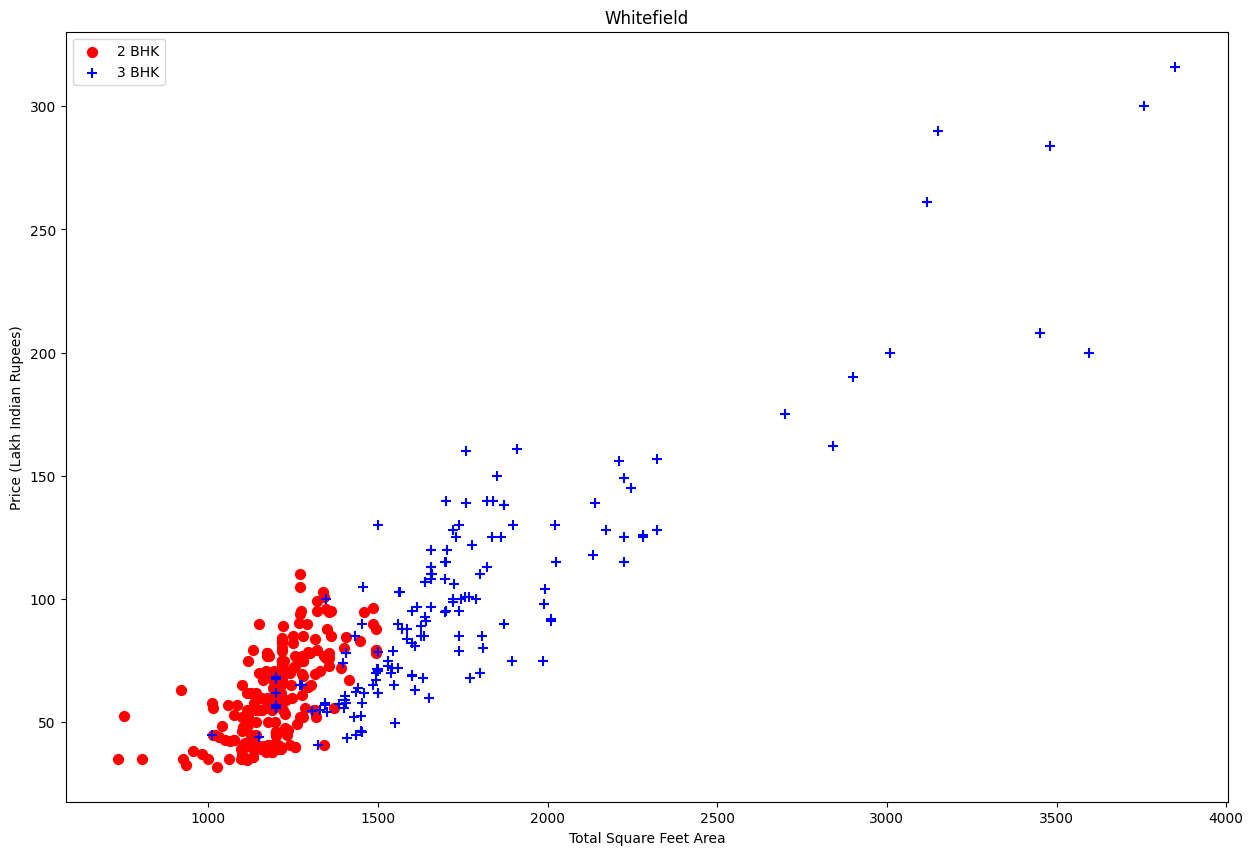

In [40]:
plot_scatter_chart(data,"Whitefield")

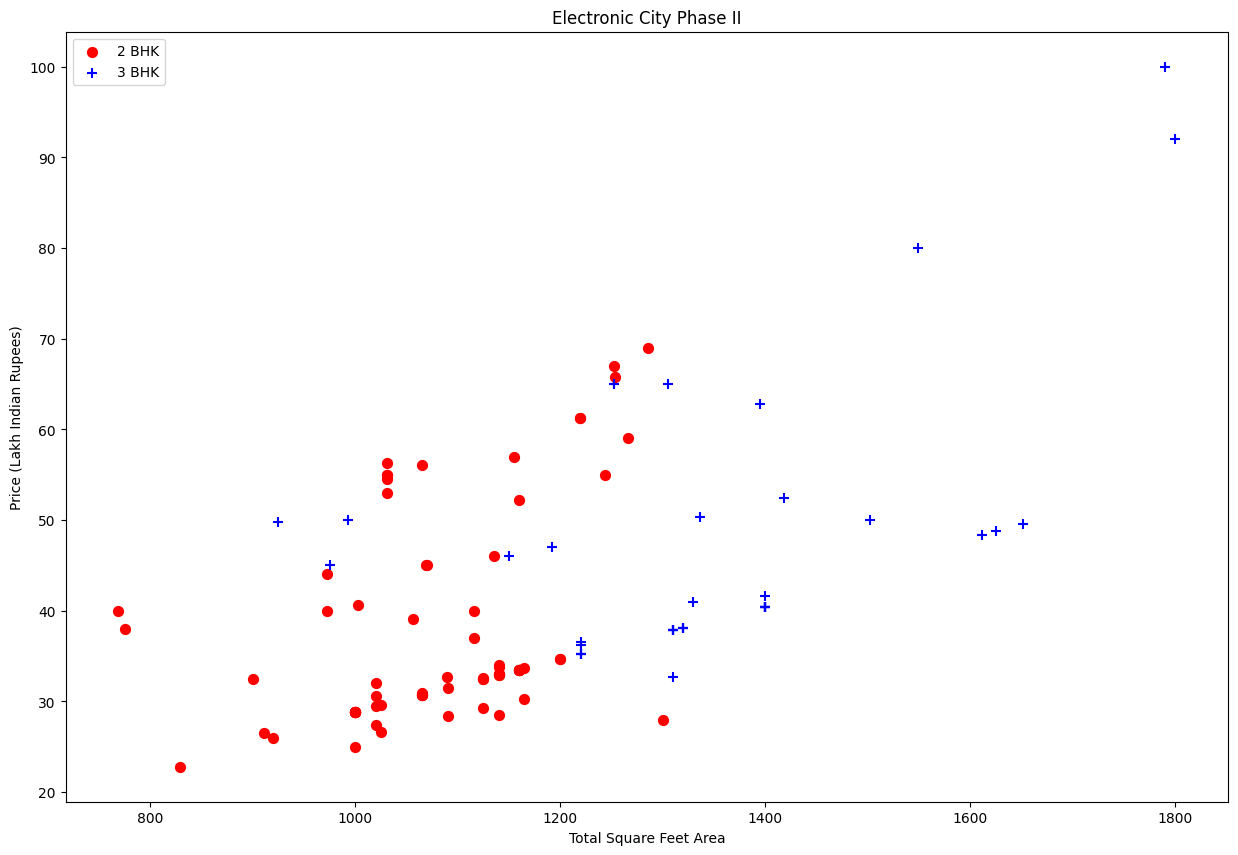

In [41]:
plot_scatter_chart(data,"Electronic City Phase II")

It can be seen that some of the 3bhk apartments have lower prices than 2bhk apartments for the same location, with the same sqft area.

For a given location build a dictionary of stats per bhk and then remove those (n)bhk apartments whose price_per_sqft is less than the mean price_per_sqft of (n-1)apartment.

In [42]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

In [43]:
data = remove_bhk_outliers(data)

data.shape

(7317, 6)

Plotting the same charts again

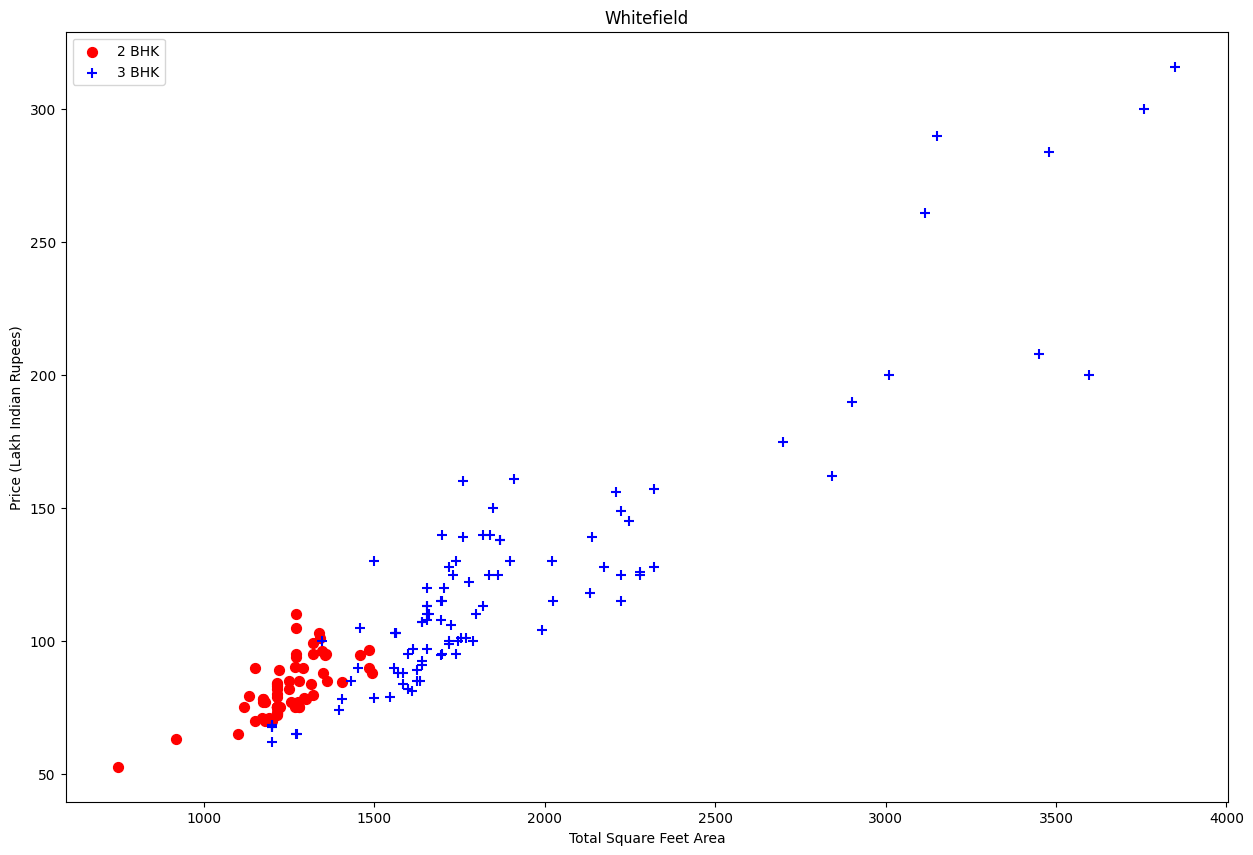

In [44]:
plot_scatter_chart(data,"Whitefield")

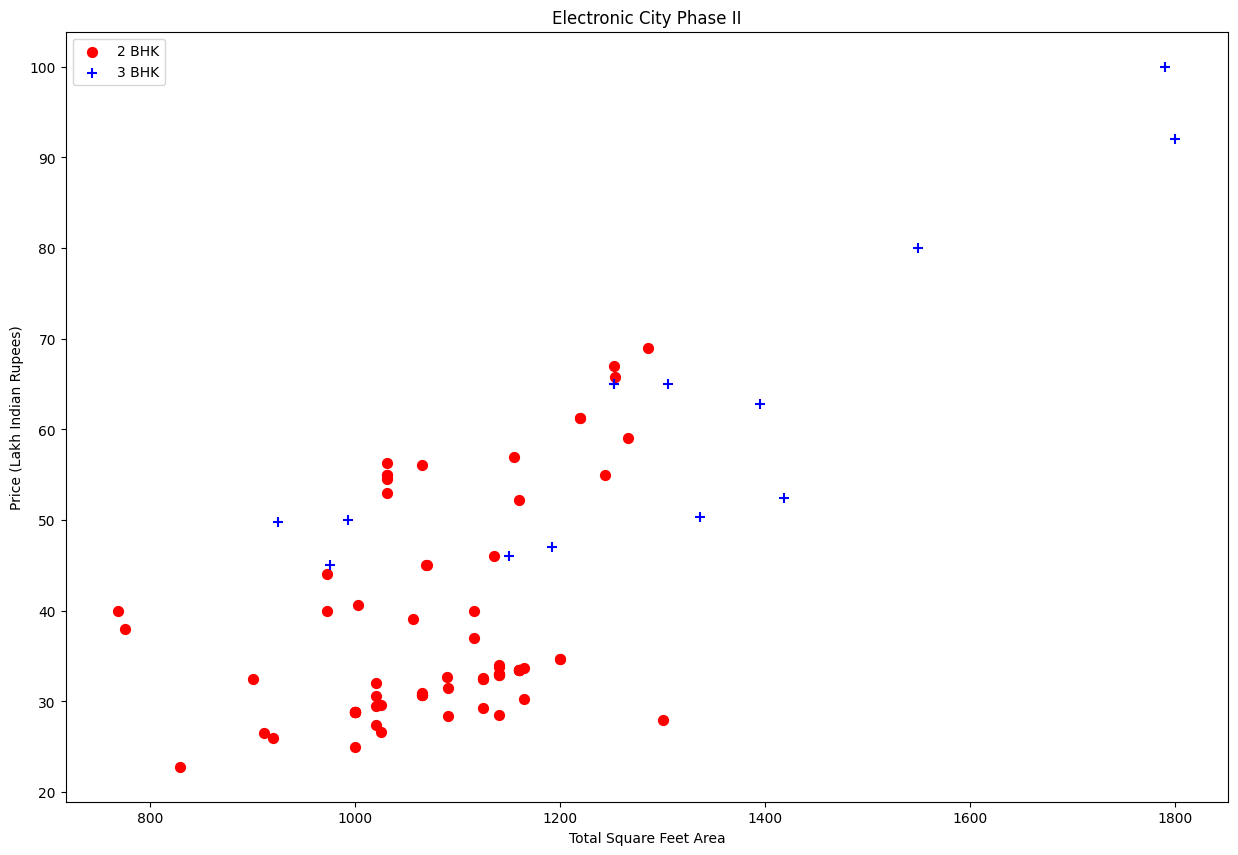

In [45]:
plot_scatter_chart(data,"Electronic City Phase II")

 _Plotting Histograms_

array([[<Axes: title={'center': 'bath'}>,
        <Axes: title={'center': 'balcony'}>],
       [<Axes: title={'center': 'price'}>, <Axes: >]], dtype=object)

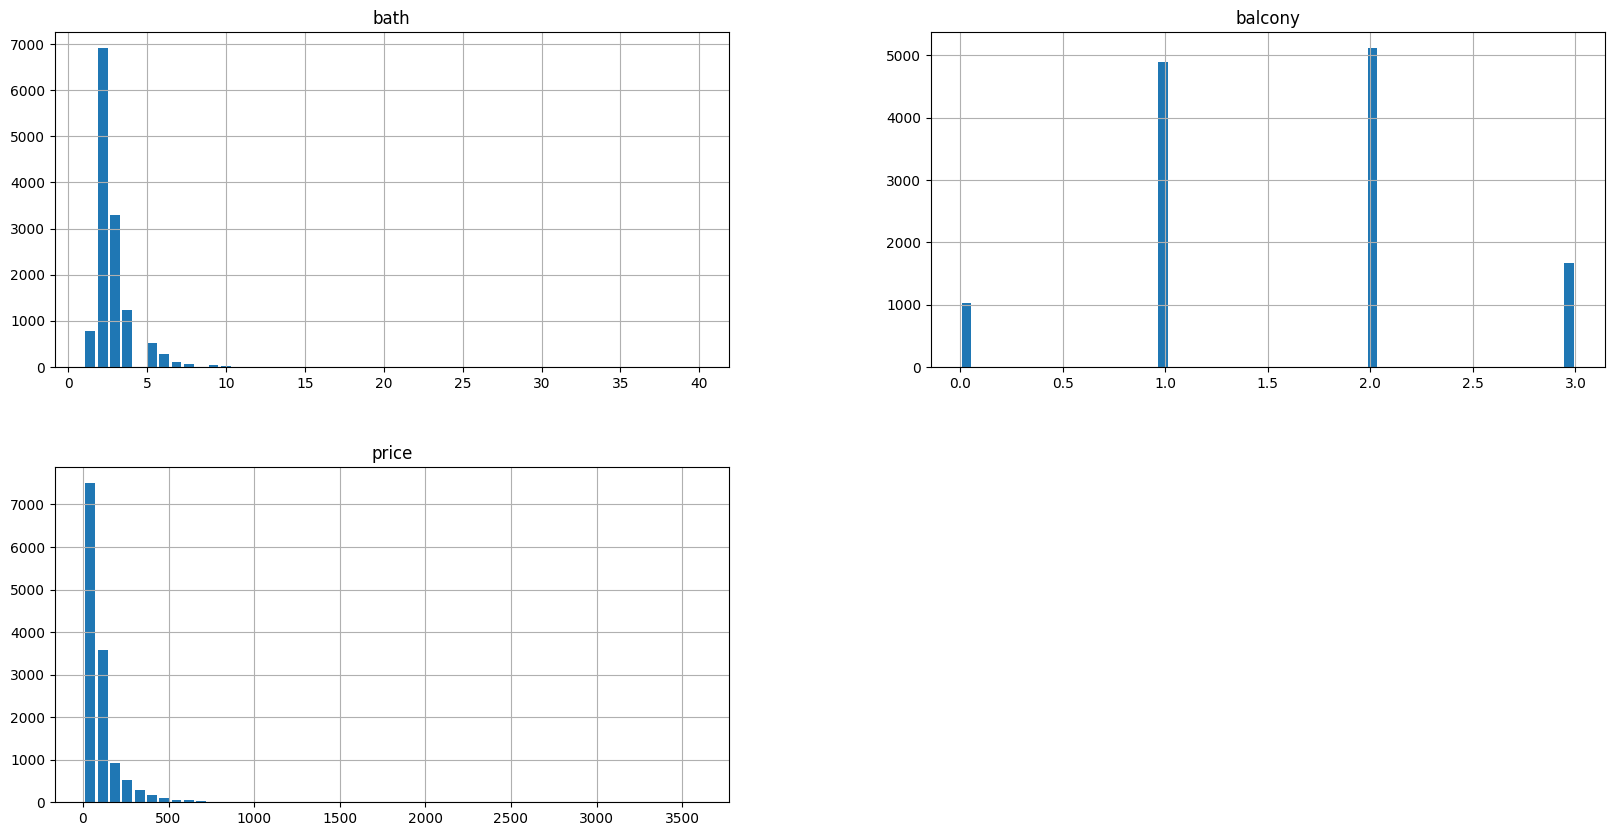

In [46]:
housing_data.hist(bins=50, figsize=(20, 10), rwidth=0.8)

Text(0, 0.5, 'Count')

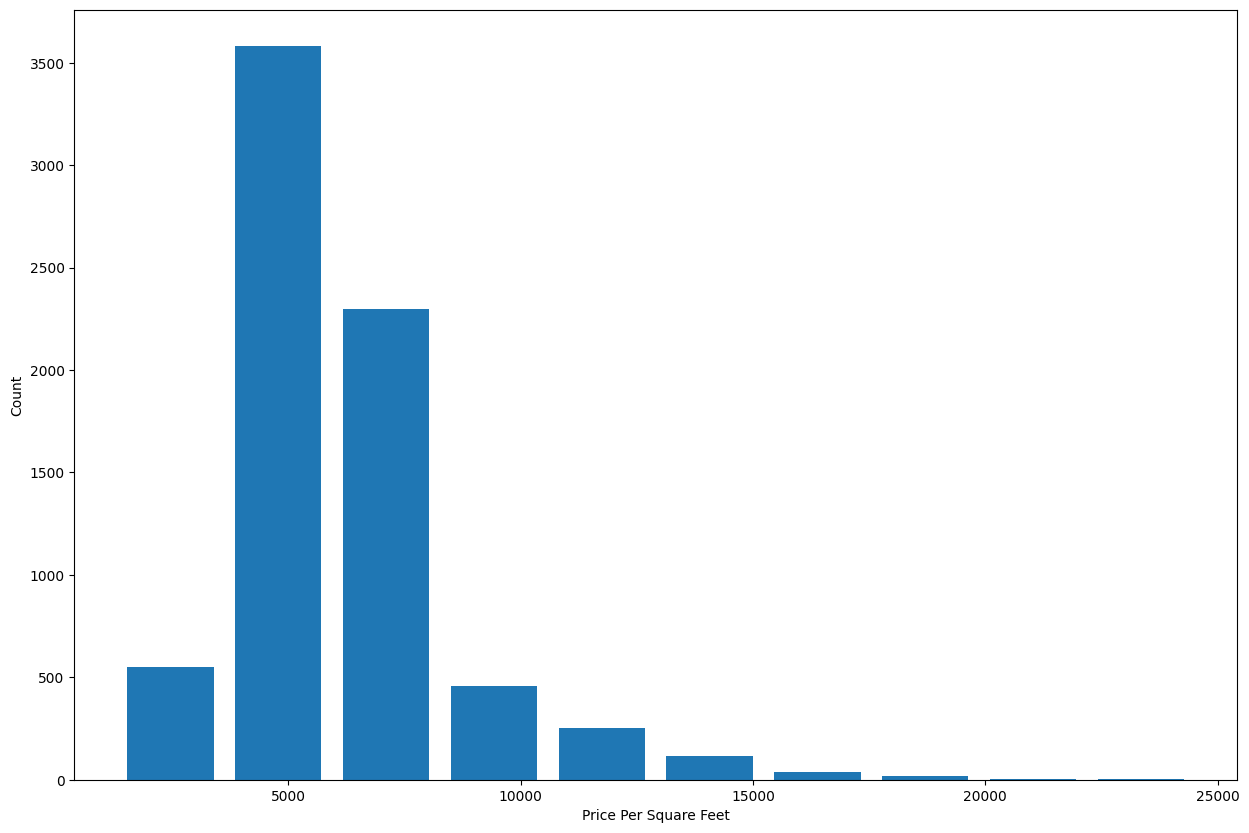

In [47]:
plt.hist(data.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

##### _Remove Outliers Using Bathroom Feature_

In [48]:
data.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'Count')

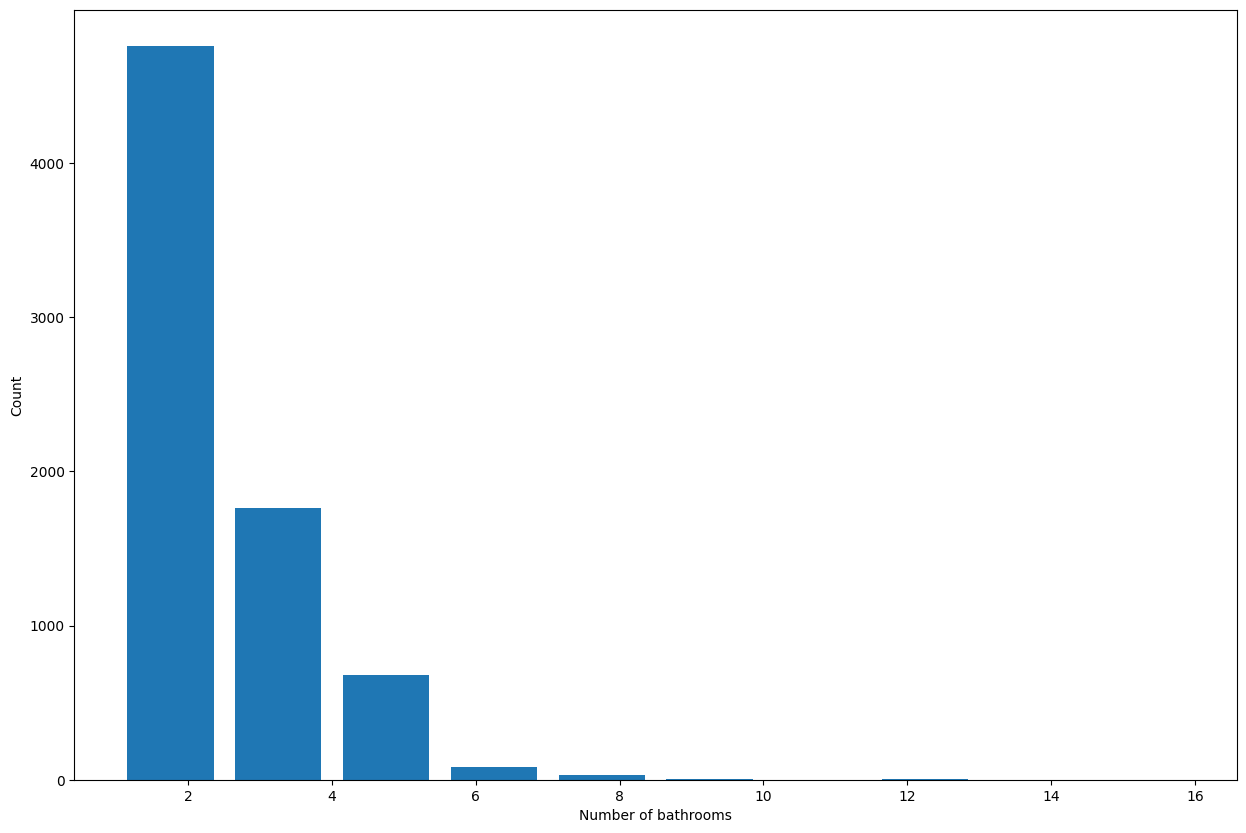

In [49]:
plt.hist(data.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [50]:
data[data.bath>10]

,location,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,4000.0,12.0,160.0,10,4000.000000
8483,other,12000.0,12.0,525.0,10,4375.000000
8572,other,10000.0,16.0,550.0,16,5500.000000
9306,other,6000.0,12.0,150.0,11,2500.000000
9637,other,5425.0,13.0,275.0,13,5069.124424


It's unusual to have more than one extra bathrooms than bedrooms in an apartment.

In [51]:
data[data.bath>data.bhk+2]

,location,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,1806.0,6.0,116.0,3,6423.034330
8408,other,11338.0,9.0,1000.0,6,8819.897689


Generally, Total Bath = Total Bed + 1 Max

Anything above this is an outlier.

In [52]:
data = data[data.bath<data.bhk+2]

data.shape

(7239, 6)

In [53]:
data.head()

,location,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,1235.0,2.0,148.0,2,11983.805668


In [54]:
data = data.drop(['price_per_sqft'],axis='columns')

data.head()

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


##### Use One Hot Encoding For Location

In [55]:
dummies = pd.get_dummies(data.location)

dummies = dummies.astype(int)

dummies.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
data = pd.concat([data,dummies.drop('other',axis='columns')],axis='columns')

data.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
data = data.drop('location',axis='columns')

data.head()

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Separating Features & Labels

In [58]:
features = data.drop(['price'],axis='columns')

features.head()

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
features.shape

(7239, 243)

In [60]:
label = data.price

label.head()

0    428.0
1    194.0
2    235.0
3    130.0
4    148.0
Name: price, dtype: float64

In [61]:
len(label)

7239

##### Splitting data into train and test set

In [62]:
features_train, features_test, label_train, label_test = train_test_split(features, label, test_size=0.2, random_state=10)

print(f"Rows in features train set : {len(features_train)}\nRows in features test set : {len(features_test)}\nRows in labels train set : {len(label_train)}\nRows in labels test set : {len(label_test)}")

Rows in features train set : 5791
Rows in features test set : 1448
Rows in labels train set : 5791
Rows in labels test set : 1448


##### Building a Model

In [63]:
linear_model =  LinearRegression() 

In [64]:
linear_model.fit(features_train,label_train)

LinearRegression()

In [65]:
linear_model_score = linear_model.score(features_test,label_test)

linear_model_score

0.8629132245229447

##### Evaluating the Model using Cross Validation

In [66]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), features, label, cv=cv)

array([0.82702546, 0.86027005, 0.85322178, 0.8436466 , 0.85481502])

##### Finding Best Model

In [67]:
models = ["Linear Regression", "DecisionTreeRegressor", "RandomForestRegressor", "Lasso"]

scores = []

scores.append(linear_model_score)

In [68]:
dtr_model = DecisionTreeRegressor()

dtr_model.fit(features_train,label_train)

dtr_model_score = dtr_model.score(features_test,label_test)

dtr_model_score

0.6952687812536488

In [69]:
scores.append(dtr_model_score)

In [70]:
rfr_model = RandomForestRegressor()

rfr_model.fit(features_train,label_train)

rfr_model_score = rfr_model.score(features_test,label_test)

rfr_model_score

0.777295043253195

In [71]:
scores.append(rfr_model_score)

In [72]:
lasso_model = Lasso()

lasso_model.fit(features_train,label_train)

lasso_model_score = lasso_model.score(features_test,label_test)

lasso_model_score

0.7184797447099163

In [73]:
scores.append(lasso_model_score)

##### Comparing the Models

###### compare it using cross_validation_score.. using just scores here

In [74]:
compare = pd.DataFrame({'model': models, 'score': scores})

compare

,model,score
0,Linear Regression,0.862913
1,DecisionTreeRegressor,0.695269
2,RandomForestRegressor,0.777295
3,Lasso,0.718480


Based on the above results, it can be said that the Linear Regression gives the best score.

Use Linear Regression Model

##### Test the Model

In [75]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(features.columns==location)[0][0]

    x = np.zeros(len(features.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return linear_model.predict([x])[0]

In [76]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

C:\Users\shubh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


83.86570258311392

In [77]:
predict_price('1st Phase JP Nagar',1000, 3, 3)

C:\Users\shubh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


86.08062284986171

In [78]:
predict_price('Indira Nagar',1000, 3, 3)

C:\Users\shubh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


195.5268975985442

##### Export the Model as Pickle File

In [79]:
with open('banglore_house_prices_model.pickle','wb') as f:
    pickle.dump(linear_model,f)

print("Successfully saved the model as 'banglore_house_prices_model.pickle' !")

Successfully saved the model as 'banglore_houe_prices_model.pickle' !


Export location and column information to a json file, to use later.

In [80]:
import json
columns = {
    'data_columns' : [col.lower() for col in features.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))

print("Successfully saved the column info as 'columns.json' !")

Successfully saved the column info as 'columns.json' !
